In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import math
import random
from sklearn.metrics import mean_squared_error

import os, warnings
warnings.filterwarnings('ignore')

In [3]:
ds = nc.Dataset(r'./Data/ERA5/Iran/isobaric.nc')

In [34]:
print(ds.variables['t_0001'][-1,:,0,0])
print(ds.variables['t_0005'][-1,:,0,0])
print(ds.variables['level'][1].data)
v1 = ds.variables['t_0001'][-1, 1, 0, 0]
v2 = ds.variables['t_0005'][-1, 1, 0, 0]
print(isinstance(v1, np.ma.MaskedArray))
print(isinstance(v2, np.ma.MaskedArray))

[-- --]
[274.69892795 281.09855669]
1000
True
False


In [40]:
def create_avgGriddedData(ds, coordinates, var_names, level):
    #y: 
    llat, ulat = coordinates[0:2]
    #x: 
    llon, rlon = coordinates[2:]
    
    #parameter to increase area
    alpha = 2
    # resolution
    scale = 0.25
    
    #Name of the variables
    lat_name = var_names[0]
    lon_name = var_names[1]
    time_name = var_names[2]
    data_name1 = var_names[3]
    data_name2 = var_names[4]
    
    #Find pixel-range based on the provided lat-lon
    lats = ds.variables[lat_name][:]
    lons = ds.variables[lon_name][:]
    
    ver_pix = [i for i in range(0, len(lats)) if lats[i] >= llat-alpha*scale and lats[i] <= ulat+alpha*scale]
    print(ver_pix[1:3])
    hor_pix = [i for i in range(0, len(lons)) if lons[i] >= llon-alpha*scale and lons[i] <= rlon+alpha*scale]
    print(hor_pix[1:3])
    
    # coordinates of selected area
    sel_crdnt = [(v, h) for v in ver_pix for h in hor_pix]
    print (len(sel_crdnt))
    
    # Convert time to datetime format
    times = ds.variables[time_name][:]
    #time_unit = 'hours since 1900-01-01 00:00:00.0'
    dates = nc.num2date(times[:], units=ds.variables[time_name].units)
    
    # Create dataframe for mean temperature based on time and level
    df = pd.DataFrame(columns=['time'])

    pressure_level = ds.variables['level'][level].data
    print('pressure level is ', pressure_level)
    col_name = 't_'+str(pressure_level)
    df['time'] = dates[:]
    df.set_index(['time'], inplace=True)

    for i in range(len(dates)):
        s = 0
        #print('time: ', dates[i])
        for lat_i, lon_i in sel_crdnt:
            v1 = ds.variables[data_name1][i, level, lat_i, lon_i]
            v2 = ds.variables[data_name2][i, level, lat_i, lon_i]
            v = v2 if isinstance(v1, np.ma.MaskedArray) else v1
            s += v
    
        df.at[dates[i], col_name] = float(s/len(sel_crdnt))

    return df
    

In [ ]:
df = create_avgGriddedData(ds, [27.0456, 31.6696, 50.6032, 55.5801], ['latitude', 'longitude', 'time', 't_0001', 't_0005'], 1)

[62, 63]
[39, 40]
840
pressure level is  1000


In [ ]:
path = r'./Data/ERA5/Iran/'
#df.head()
df.to_csv(path+'Isobaric_levels_temperature.csv')

In [ ]:
# Forecasting and benchmarking

def benchmarking(df, no_exper = 10):
    end_index_of_df = len(df)
    
    levels_array = [1000, 900, 800, 700, 600, 500]
    no_of_experiments = no_exper

    alpha = 0.7 #Minimum percentage of samples for train
    previous_time = int(alpha * end_index_of_df)
    #previous_time = 2880
    previous_observations = int(previous_time / 6)

    res = {'Isobaric level':[], 'RMSE':[]}

    for level in levels_array:
        col_name = 't_'+str(level)
        #print('Pressure level: ', level)
        
        res['Isobaric level'].append(level)
        
        rmse_array = []
        for _ in range(no_of_experiments):
            y_hat_avg = pd.DataFrame(columns=['time', col_name, 'predicted_t', 'naive', 'aver'])
            seperate_index = random.randint(previous_time, end_index_of_df-1)
            train = df[col_name][0: seperate_index]
            test = df[col_name][seperate_index:seperate_index+1]
           
            y_hat_avg['time'] = df['time'][seperate_index:seperate_index+1]
            y_hat_avg[col_name] = test.copy()
            
            print('computation started')
         
            fit1 = ExponentialSmoothing(np.asarray(train), seasonal_periods=288, trend='add', seasonal='add', ).fit()
            y_hat_avg['predicted_t'] = fit1.forecast(len(test))
            print('computation completed')

            # computing the error for exponential smoothing
            a = y_hat_avg[col_name]
            b = y_hat_avg['predicted_t']
       
            rmse_value = np.sqrt(np.mean((b - a) ** 2))
            rmse_array.append(rmse_value)
        res['RMSE'].append(rmse_array)
     
    return res

In [5]:
file = r'./Data/ERA5/Iran/Isobaric_levels_temperature.csv'
df = pd.read_csv(file)

results = benchmarking(df, 50)
print("Finish benchmarking comparison")


Pressure level:  1000
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation 

computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
Pressure level:  600
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation completed
computation started
computation c

       1000      900       800       700       600       500 
0  0.075598  0.198110  0.003605  0.052164  0.085147  0.078869
1  0.151167  0.046480  0.063013  0.398816  0.008154  0.322930
2  0.125301  0.000443  0.071357  0.096930  0.115907  0.006143
3  0.130810  1.094763  0.044316  0.020780  0.080641  0.067214
4  0.598025  0.345865  0.102087  0.005474  0.073783  0.067586


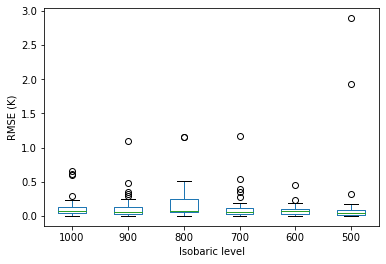

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
#print(results)

res = pd.DataFrame(columns=results['Isobaric level'])
cols = res.columns
for i in range(len(cols)):
    res[cols[i]] = results['RMSE'][i]
print(res.head())

res.to_csv(r'./isobaricRMSE.csv')

p = res.boxplot(grid=False)
p.set_xlabel('Isobaric level')
p.set_ylabel('RMSE (K)')

plt.savefig(r'./isobaric.jpg', dpi=400)
plt.show()